Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm
import random

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Check cuda availible

In [2]:
assert True == torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Calculate mean and std

In [3]:
# files = [file for file in os.listdir("trainval")]

# means = [0,0,0]
# stds = [0,0,0]

# for i in tqdm.tqdm(range(len(files))):
#     file = files[i]
#     img = torchvision.io.read_image(f"trainval/{file}").to(torch.float).to(device)
#     img = img / 256.0
#     for j in range(3):
#         means[j] += img[j].mean()
#         stds[j] += (img[j]**2).sum()

# for j in range(3):
#     means[j] /= (len(files))
#     stds[j] /= (40 * 40 * len(files))
#     stds[j] -= means[j]**2
#     stds[j] = torch.sqrt(stds[j])

#     # means[j] = int(means[j])
#     # stds[j] = int(stds[j])


# print(means)
# print(stds)

Create dataloaders

In [4]:
means = (0.5669, 0.5426, 0.4914)
stds = (0.2377, 0.2326, 0.2506)

class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize(means, stds)
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.8),
            transforms.RandomApply([v2.RandomAffine(degrees=10)], p=0.8),
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device) / 256.0
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.01, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [5]:
train_loader = DataLoader(train_dataset, 32, True)
val_loader = DataLoader(val_dataset, 32, True)

Test augmentations

In [ ]:
# def imshow(img):
#     for i in range(3):
#         img[i] = img[i] * stds[i] + means[i]
#     npimg = img.to("cpu").numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
#     print(img.shape)

# imshow(train_dataset[2][0])


Shake Drop

In [7]:
class ShakeDropFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, training=True, p_drop=0.5, alpha_range=[-1, 1]):
        if training:
            gate = torch.cuda.FloatTensor([0]).bernoulli_(1 - p_drop)
            ctx.save_for_backward(gate)
            if gate.item() == 0:
                alpha = torch.cuda.FloatTensor(x.size(0)).uniform_(*alpha_range)
                alpha = alpha.view(alpha.size(0), 1, 1, 1).expand_as(x)
                return alpha * x
            else:
                return x
        else:
            return (1 - p_drop) * x

    @staticmethod
    def backward(ctx, grad_output):
        gate = ctx.saved_tensors[0]
        if gate.item() == 0:
            beta = torch.cuda.FloatTensor(grad_output.size(0)).uniform_(0, 1)
            beta = beta.view(beta.size(0), 1, 1, 1).expand_as(grad_output)
            beta = Variable(beta)
            return beta * grad_output, None, None, None
        else:
            return grad_output, None, None, None


class ShakeDrop(nn.Module):

    def __init__(self, p_drop=0.5, alpha_range=[-1, 1]):
        super(ShakeDrop, self).__init__()
        self.p_drop = p_drop
        self.alpha_range = alpha_range

    def forward(self, x):
        y = ShakeDropFunction.apply(x, self.training, self.p_drop, self.alpha_range)
        return y

Train/Test funcs


In [8]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(loader):

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        if scheduler is not None:
            print(f"Epoch {epoch + 1} | lr={scheduler.get_last_lr()[0]}")
        else:
            print(f"Epoch {epoch + 1}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model, "model.pth")
        
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [9]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)
# net.features[3][0].block[0][0].stride = (1, 1)

myblock = nn.Sequential(
    nn.BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    ShakeDrop(),
)

net.classifier[0].p = 0.8
net.features[4][5].block[3][1] = myblock

# print(net)

In [10]:
net = net.to(device)

net = torch.nn.DataParallel(net).cuda()

Training

In [11]:
torch.manual_seed(1984)
random.seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benckmark = True

epochs = 46

base_optimizer = optim.SGD
optimizer  = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [30, 45])
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/3094 [00:00<?, ?it/s]C:\Users\ryabo\AppData\Local\Temp\ipykernel_7840\1788586028.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:85.)
  gate = torch.cuda.FloatTensor([0]).bernoulli_(1 - p_drop)
  0%|          | 0/3094 [00:00<?, ?it/s]


KeyboardInterrupt: 

Plots

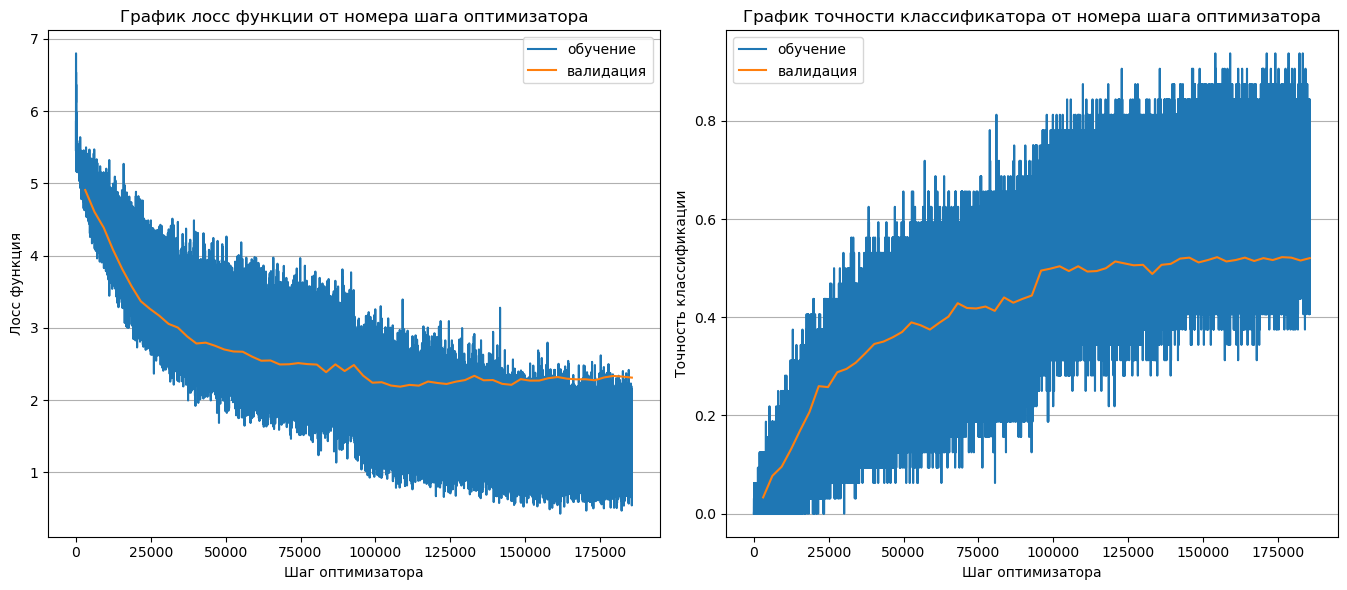

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].grid(axis = "y")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].grid(axis = "y")
ax[1].legend()

plt.tight_layout()
plt.show()

Load model (if needed)

In [14]:
# net = torch.load("checkpoint.pth", weights_only=False)
# net = net.to(device)
# net.eval()

Test Time Augmentation

In [15]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        normalize = v2.Normalize(means, stds)
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.8),
            transforms.RandomApply([v2.RandomAffine(degrees=10)], p=0.8),
        ])
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device) / 256.0
        img = normalize(img)
        res = []
        for i in range(10):
            logits = net(augmentations(img).unsqueeze(0))[0]
            res.append(int(logits.argmax().to("cpu")))
        
        pred.append(max(res, key=lambda x: res.count(x)))


100%|██████████| 10000/10000 [21:48<00:00,  7.64it/s]


In [17]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [18]:
df.to_csv("labels_test.csv", index=False)